In [ ]:
import distrax
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import codex.ems.equinox as ceqx

# Plotting parameters
papr_rc_params = {
  'legend.fancybox': True,
  'figure.dpi': 600,
}
plt.rcParams.update(papr_rc_params)
%config InlineBackend.figure_formats = ['svg']

# Density Estimation

Given a set of i.i.d. samples from an unknown true distribution $p_{\text{data}}$, we aim to
find the parameters of a density model $q_{\theta}$ that best describe this
target distribution. In particular, the Kullback-Leibler divergence between the
model and the true distribution $\mathbb{KL}(p_{\text{data}}, q_{\theta})$ is often use to
measure the quality of fit. We express it as the following objective:


$$ \hat{\theta} = \mathrm{argmin}_{\theta} \mathbb{KL}(p_{\text{data}}, q_{\theta}) $$

where $ \mathbb{KL}(p_{\text{data}}, q_{\theta}) = \mathbb{E}\left[ \log  p_{\text{data}} (X) \right] - \mathbb{E}\left[ \log q_{\theta} (X) \right]$ with $ X \sim p_{\text{data}} $. Since the first term doesnt not depend on $\theta$, the objective reduces to,

$$ \hat{\theta} = \mathrm{argmax}_{\theta} \mathbb{E}\left[ \log  q_{\theta} (X) \right] $$

Although we cannot compute this expectation directly since we don't know $p_{\text{data}}$, we do have access to data to approximate the expectation, using the law of large number.

$$ \mathbb{E}\left[ \log  q_{\theta} (X) \right] = \frac{1}{n} \sum_{i=1}^n \log q_{\theta} (X_i)  = l(\theta) $$

which corresponds to the log-likelihood function.


## Example

Let us consider our multi-modal target univariate distribution to be a mixture of $K$ gaussians,

$$ p_{\text{data}} = \sum_{i=1}^K w_i N(\mu_i, \sigma_i) $$

where we will assign the weights $w_i$, means $\mu_i$,  and standard deviation $\sigma_i$ by valid random values.

In [ ]:
# Mixture of K Gaussians
def get_gaussian_mixture_dist(k=10, key=random.key(42)):
  sigma_max = 10.0 / (6.0 * k)
  mixture = distrax.MixtureSameFamily(
      mixture_distribution=distrax.Categorical(
          probs=jnp.ones(k, dtype=jnp.float32)
      ),
      components_distribution=distrax.Normal(
          loc=random.uniform(key=key, minval=-0.5, maxval=0.3, shape=(k,)),
          scale=random.uniform(
              key=key,
              minval=0.25 * sigma_max,
              maxval=0.35 * sigma_max,
              shape=(k,),
          ),
      ),
  )
  return mixture

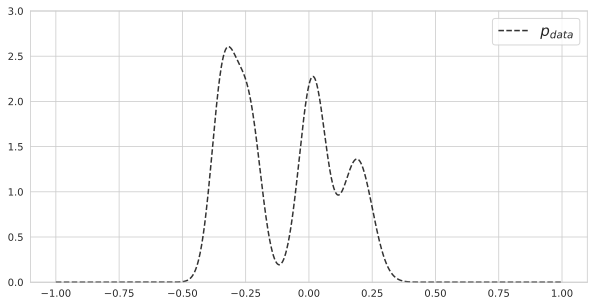

In [ ]:
# Reproducibility
rng = random.key(42)

# Plot data distribution
x = jnp.linspace(-1, 1, 1001).astype(jnp.float32)
fig = plt.figure(figsize=(10, 5))
target = get_gaussian_mixture_dist(k=10, key=rng)
plt.plot(
    x,
    target.prob(x),
    "black",
    alpha=0.8,
    label="$p_{data}$",
    linestyle="dashed",
)
plt.ylim(0, 3.0)
plt.legend(loc="best", fontsize=15)
plt.show()

It must be noted, **in practice we will not have access to this distribution rather only to samples from it.**

Given the zero tails of the data distribution on each extreme of the range $[-1, 1]$, we could treat this as a circular pdf with period of $2$

Moreover, **our data distribution (mixture of $10$ gaussians) has a total of $29$ parameters.**

## Fourier Basis Density Model


In our paper ([arxiv](https://arxiv.org/pdf/2402.15345)), we introduce a lightweight, flexible parametrization of a univariate distribution by a constrained Fourier series basis. For the periodic distribution case (P=$2$), we obtained the following representation,

$$ q_{\theta}(x) = \frac12 + \sum_{i=1}^N \text{Re} \left( \frac{c_n}{c_0} \exp( i n \pi x ) \right) $$


where $c_n = \sum_{k=0}^{N-n} a_k a_{N-k}^*$, and $a_n$ is an arbitrary sequence of complex numbers that our model aims to learn ($\theta \equiv \left[ a_n \right]_0^N $).

In [ ]:
# Probability Model (Periodic Fourier Model)
model = ceqx.PeriodicFourierEntropyModel(rng, num_pdfs=1, num_freqs=14, period=2.0)

Since every complex number $a_n$, contains two float values. Our initial periodic model has a total of $2N$ parameters, where $N$ is the number of frequency terms. For our case, we could take $N=14$. These parameters are initialized randomly and through stochastic gradient descent we learn best parameters to fit the density.

Initial Model NLL: 0.914525


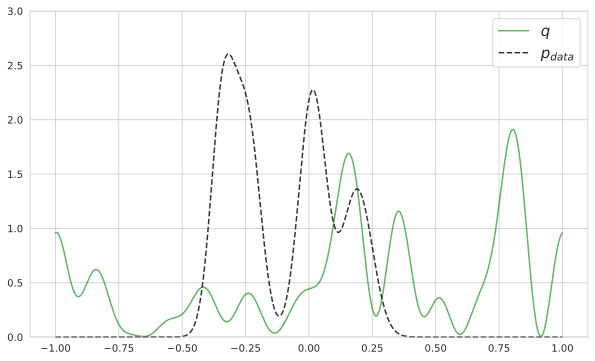

In [ ]:
## Validation Dataset
val_size = 1024
val_data = target.sample(seed=rng, sample_shape=(val_size,))

## Evaluate Negative Log Likelihood
nll = model.neg_log_prob(val_data).mean()
print(f"Initial Model NLL: {nll:.6f}")

## Plot Initial Model
fig = plt.figure(figsize=(10, 6))
plt.plot(x, model.prob(x), "green", alpha=0.6, label='$q$')
plt.plot(
    x,
    target.prob(x),
    "black",
    alpha=0.8,
    label="$p_{data}$",
    linestyle="dashed",
)
plt.ylim(0, 3.0)
plt.legend(loc="best", fontsize=15)
plt.show()

### Model Training

In [ ]:
## Training hyperparameters
steps = 30000
batch_size = 32
learning_rate = 1e-3
optim = optax.adam(learning_rate) # Adam as optimizer

@eqx.filter_grad
def compute_grad_loss(model, x):
  # We aim to minimize negative log likelihood
  nll = jax.vmap(model.neg_log_prob)(x)
  return nll.mean()

@eqx.filter_jit
def make_step(model, x, opt_state):
  grads = compute_grad_loss(model, x)
  updates, opt_state = optim.update(grads, opt_state)
  model = eqx.apply_updates(model, updates)
  return model, opt_state

## Training Loop
nll_loss = []
opt_state = optim.init(model)
for i in range(steps):
  rng, _ = random.split(rng)
  batch = target.sample(seed=rng, sample_shape=(batch_size,))
  model, opt_state = make_step(model, batch, opt_state)

  # Validation
  if i % 1000 == 0:
    loss = jax.vmap(model.neg_log_prob)(val_data).mean()
    nll_loss.append(loss.item())

### Model Evaluation

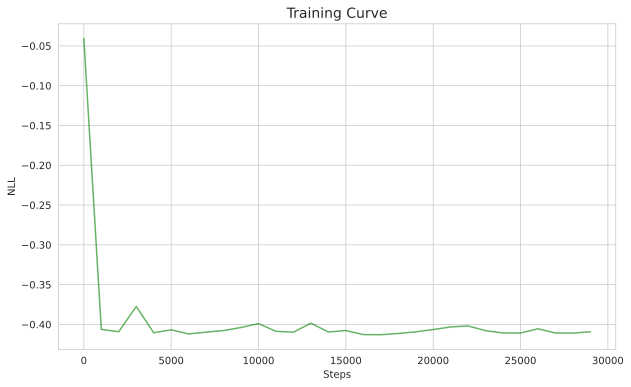

In [ ]:
## Plot Training Curve
fig = plt.figure(figsize=(10, 6))
plt.title("Training Curve", fontsize=14)
plt.ylabel("NLL")
plt.xlabel("Steps")
plt.plot(jnp.arange(0,steps,1000).tolist(), nll_loss, "green", alpha=0.6, label='$q$')
plt.show()

Trained Model NLL: -0.410008


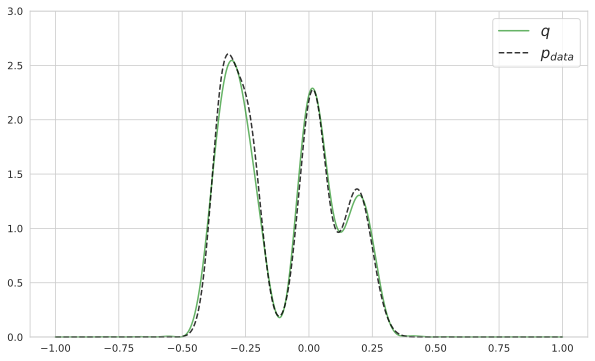

In [ ]:
## Evaluate Negative Log Likelihood
nll = model.neg_log_prob(val_data).mean()
print(f"Trained Model NLL: {nll:.6f}")

## Plot Trained Model
fig = plt.figure(figsize=(10, 6))
plt.plot(x, model.prob(x), "green", alpha=0.6, label='$q$')
plt.plot(
    x,
    target.prob(x),
    "black",
    alpha=0.8,
    label="$p_{data}$",
    linestyle="dashed",
)
plt.ylim(0, 3.0)
plt.legend(loc="best", fontsize=15)
plt.show()

**Our model was able to efficiently (one less parameter) capture the modes of the data distribution.** 🤩